In [13]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport

import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

alt.data_transformers.enable('json')
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [77]:
# load csv
df = pd.read_csv('../data/raw.csv')

In [78]:
# drop unecessary index column
df = df.drop(df.columns[0], 1)

# Add column names
new_col_names = ['Sex',
                 'Age',
                 'Debt',
                 'Married',
                 'BankCustomer',
                 'EducationLevel',
                 'Ethnicity',
                 'YearsEmployed',
                 'PriorDefault',
                 'Employed',
                 'CreditScore',
                 'DriversLicense',
                 'Citizen',
                 'ZipCode',
                 'Income',
                 'Approved'
                ]

df.columns = new_col_names

In [79]:
# split test and train data
X = df.drop(['Approved'], 1)
y = df[['Approved']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [80]:
# create pandas profiling report
train_df = X_train.join(y_train)
profile = ProfileReport(df, title='Pandas Profiling Report')

In [81]:
profile.to_file(output_file="../doc/report.html")

**Link to pandas profiling report:** [link](https://htmlpreview.github.io/?https://github.com/UBC-MDS/DSCI_522_Group_412/blob/master/doc/report.html)

In [82]:
X_train.describe(include = "all")

,Sex,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income
count,552,552,552.000000,552,552,552,552,552.000000,552,552,552.000000,552,552,552,552.000000
unique,3,311,NaN,4,4,15,10,NaN,2,2,NaN,2,3,143,NaN
top,b,?,NaN,u,g,c,v,NaN,t,f,NaN,f,g,00000,NaN
freq,377,9,NaN,409,409,109,321,NaN,283,315,NaN,302,503,106,NaN
mean,NaN,NaN,4.604520,NaN,NaN,NaN,NaN,2.048134,NaN,NaN,2.400362,NaN,NaN,NaN,920.070652
std,NaN,NaN,4.807331,NaN,NaN,NaN,NaN,2.923399,NaN,NaN,4.853296,NaN,NaN,NaN,4787.304994
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,1.030000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,NaN,5.000000
75%,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,2.551250,NaN,NaN,3.000000,NaN,NaN,NaN,400.000000


# Initial observations
- There are no missing values, but there are many features with zeroes. We should inspect these to ensure they are not errors.
- `Age` is currently a categorical feature, but should be numeric.
- `Married` is highly correlated with `BankCustomer`. We may need to remove one of these features (or combine them) to avoid issues of multicollinearity in our models.
- There are categorical features (e.g. `Citizen` and `BankCustomer`) that will need to be transformed through OHE or another method.
- The numeric features have different scales and will need to be standardized or normalized to work with some of the models we are considering.
- The dataset is well balanced, with `Approved` having 55.5% of data in one class and 45.5% in the other class.

# Data Wrangling

Although the dataset appears to have no missing values, there are several "?" across different columns, which could be missing value. Thus, we need to fill those missing values. 

In [83]:
# Dealing with missing data 
# identify ? as missing data
X_train = X_train.replace('?', np.nan)

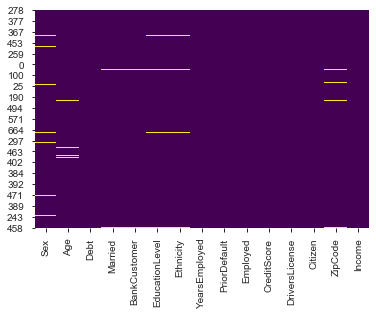

In [84]:
sns.heatmap(X_train.isnull(), cmap='viridis', cbar=False);

After we replace the "?" to missing values, we see that there are indeed some missing values. 

In [85]:
# Dealing with missing data
X_train = X_train.fillna(method = 'ffill')

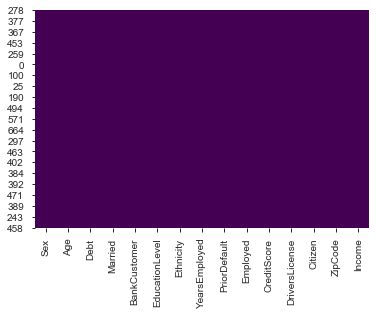

In [86]:
sns.heatmap(X_train.isnull(), cmap ='viridis', cbar = False);

Now there are no missing values in the data

In [87]:
# Change age from string to float
X_train.Age = X_train.Age.astype(float)

In [88]:
# change PriorDefault to False and True
X_train['PriorDefault'] = X_train['PriorDefault'].replace({'f': 'False', 't': 'True'})

# change Employed to False and True
X_train['Employed'] = X_train['Employed'].replace({'f': 'False', 't': 'True'})

In [89]:
# change target to 0 and 1
y_train['Approved'] = y_train['Approved'].replace({'-': 0, '+': 1})

# Data Visualization

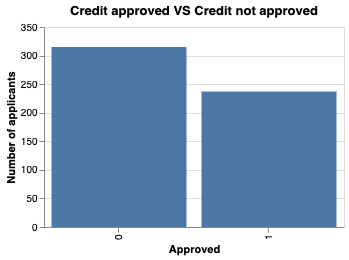

In [90]:
# Plot1 visualize the target: approved and not approved
plot1 = alt.Chart(y_train).mark_bar().encode(
    alt.X("Approved:N"),
    alt.Y("count()", title = "Number of applicants"),
).properties(width=300, height=200, title = "Credit approved VS Credit not approved")
plot1

The above graph shows that although the number of approved credit card applications does not equal to the number of not approved credit card applications, the difference is not big. This could be seen as a somewhat balanced dataset. 

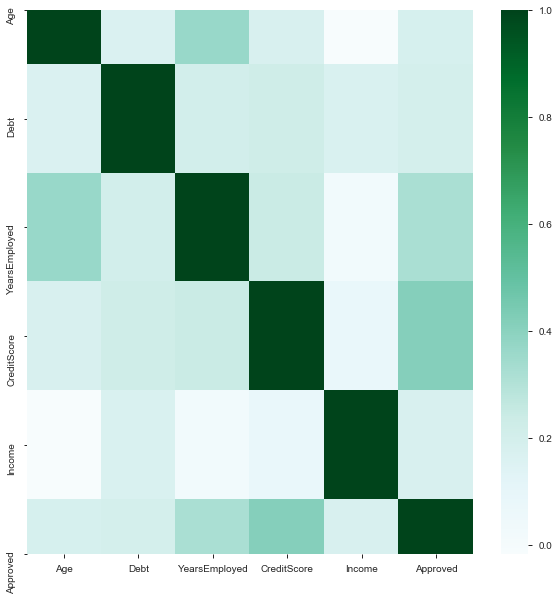

In [91]:
# plot correlation matrix for numeric variables against target
train_df = X_train.join(y_train)
plt.figure(figsize=(10,10)) 
sns.heatmap(train_df.corr(), cmap='BuGn')

The above graph shows that `CreditScore` may have a strong correlation with credit card approval (`Approved`). Next, `YearsEmployed` may also be correlated with credit card approval (`Approved`). Other variables in the correlation heat map does not show strong correlation with the target variable `Approved`.

After we explored the target and the numeric features, we still need to have a visual understanding about the categorical variables.

In [92]:
def make_plot(feature, title):
    """
    Plots the bar plot of the feature variable against the target variable

    Parameters
    ----------
    feature: string
             feature name in the dataset

    title: string
           title of the plot


    Returns
    -------
    plot: altair.vegalite.v3.api.Chart
          A bar plot of the feature variable against the target variable


    Examples
    --------
    >>> make_plot("Sex", "Approved and Sex")
    """
    
    plot = alt.Chart(train_df).mark_bar().encode(
        alt.X(feature, type = "nominal"),
        alt.Y("count()", title = "Number of approved"),
        alt.Column("Approved")
        ).properties(width=300, height=200, title = title)
    return plot

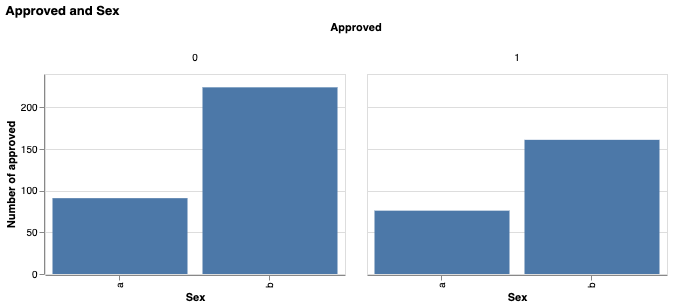

In [93]:
plot2 = make_plot("Sex", "Approved and Sex")
plot2

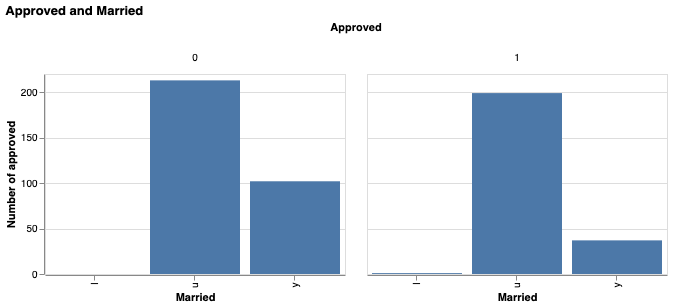

In [94]:
plot3 = make_plot("Married", "Approved and Married")
plot3

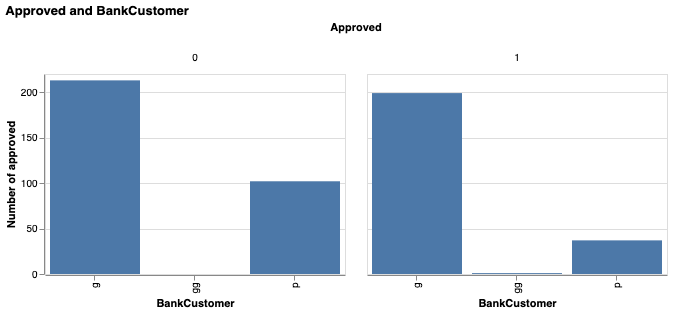

In [95]:
plot4 = make_plot("BankCustomer", "Approved and BankCustomer")
plot4

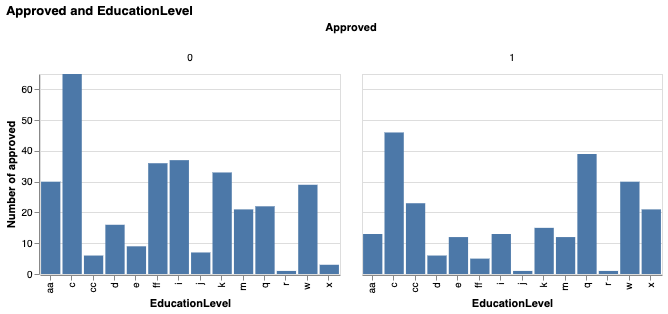

In [96]:
plot5 = make_plot("EducationLevel", "Approved and EducationLevel")
plot5

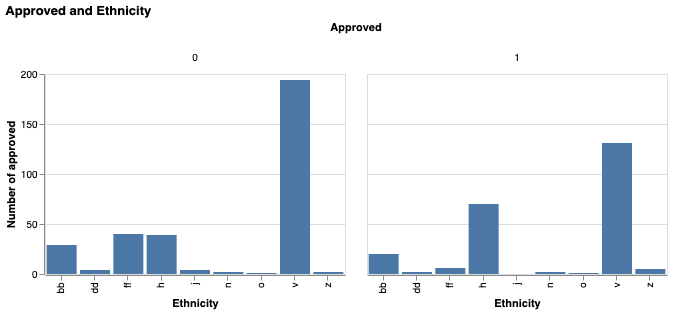

In [97]:
plot6 = make_plot("Ethnicity", "Approved and Ethnicity")
plot6

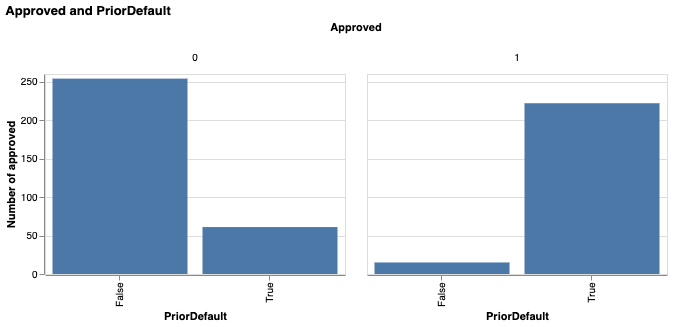

In [98]:
plot7 = make_plot("PriorDefault", "Approved and PriorDefault")
plot7

The graph above shows that `PriorDefault` is closely connected with credit approval. If a person has prior default history, it is highly possible that his/her credit card application will not be approved. On the other hand, if a person does not have prior default history, it is highly possible that his/her credit card application will be approved. 

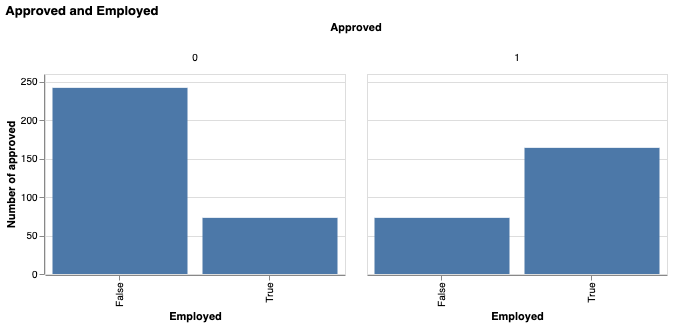

In [99]:
plot8 = make_plot("Employed", "Approved and Employed")
plot8

The graph above shows that `Employed` is closely related with to approval. If a person is not employed, it is highly possible that his/her credit card application will not be approved. On the other hand, if a person is employed, it is highly possible that his/her credit card application will be approved. 

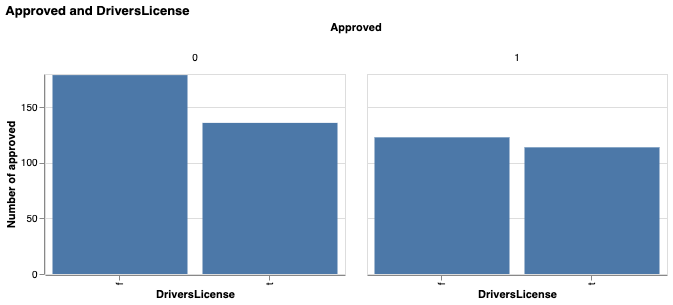

In [100]:
plot9 = make_plot("DriversLicense", "Approved and DriversLicense")
plot9

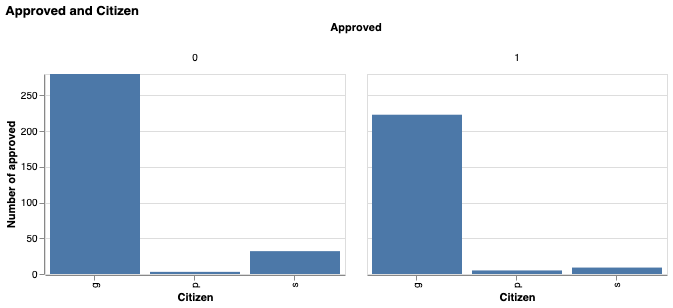

In [101]:
plot10 = make_plot("Citizen", "Approved and Citizen")
plot10